In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import random
import numpy as np
import nibabel as nib
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score

## Data preparation

In [33]:
class BrainMetastasesDataset(Dataset):
    def __init__(self, root_dir, transform=None, start_slice=0):
        self.root_dir = root_dir
        self.transform = transform
        self.scans = os.listdir(root_dir)
        self.valid_scans = self._filter_valid_scans()
        self.start_slice = start_slice

        # Dataset specifics
        self.num_classes = 4
        self.modalities = ['t1n', 't1c', 't2w', 't2f']

    # Only keep scans for which we have a segmentation file
    def _filter_valid_scans(self):
        valid_scans = []
        for scan in self.scans:
            scan_folder = os.path.join(self.root_dir, scan)
            seg_path = glob.glob(os.path.join(scan_folder, '*seg.nii'))
            if seg_path:
                valid_scans.append(scan)
        return valid_scans

    def __len__(self):
        return len(self.valid_scans)

    def __getitem__(self, idx):
        scan_folder = os.path.join(self.root_dir, self.valid_scans[idx])

        # Paths
        t1n_path = glob.glob(os.path.join(scan_folder, '*t1n.nii'))
        t1c_path = glob.glob(os.path.join(scan_folder, '*t1c.nii'))
        t2w_path = glob.glob(os.path.join(scan_folder, '*t2w.nii'))
        t2f_path = glob.glob(os.path.join(scan_folder, '*t2f.nii'))
        seg_path = glob.glob(os.path.join(scan_folder, '*seg.nii'))

        # Load images or create zero tensors if missing
        t1n = nib.load(t1n_path[0]).get_fdata() if t1n_path else np.zeros((240, 240, 155))
        t1c = nib.load(t1c_path[0]).get_fdata() if t1c_path else np.zeros((240, 240, 155))
        t2w = nib.load(t2w_path[0]).get_fdata() if t2w_path else np.zeros((240, 240, 155))
        t2f = nib.load(t2f_path[0]).get_fdata() if t2f_path else np.zeros((240, 240, 155))
        seg = nib.load(seg_path[0]).get_fdata() if seg_path else np.zeros((240, 240, 155))

        # Load only slices starting from start_slice
        sample = {
            't1n': t1n[:, :, self.start_slice:],
            't1c': t1c[:, :, self.start_slice:],
            't2w': t2w[:, :, self.start_slice:],
            't2f': t2f[:, :, self.start_slice:],
            'seg': seg[:, :, self.start_slice:]
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_stats(self, scan_sample_size=None, slice_sample_size=None):
        """
        Get statistics about the dataset including number of valid scans,
        depth of the scans, size of the images, and other details.

        Parameters:
        - scan_sample_size: Number of scans to sample for calculating statistics. If None, use all scans.
        - slice_sample_size: Number of slices to sample per scan for calculating statistics. If None, use all slices.
        """
        # Dataset and image shape
        num_scans = len(self.valid_scans)
        if num_scans > 0:
            sample = self.__getitem__(0)
            image_shape = sample['t1n'].shape  # Assuming all modalities have the same shape
            num_slices = image_shape[-1]
            height, width = image_shape[1], image_shape[2]
        else:
            image_shape = (0, 0, 0)
            num_slices = 0
            height, width = 0, 0

        # Class distribution and voxel intensities statistics
        class_counts = np.zeros(self.num_classes)
        intensity_stats = {modality: {'mean': 0, 'std': 0} for modality in self.modalities}
        num_voxels = {modality: 0 for modality in self.modalities}

        # Determine the number of scans to sample
        if scan_sample_size is None or scan_sample_size > num_scans:
            scan_sample_size = num_scans
        scan_indices = random.sample(range(num_scans), scan_sample_size)

        # Iterate over the sampled scans
        for idx in scan_indices:
            sample = self.__getitem__(idx)

            # Determine the number of slices to sample
            if slice_sample_size is None or slice_sample_size > num_slices:
                slice_sample_size = num_slices
            slice_indices = random.sample(range(num_slices), slice_sample_size)

            # Count class occurrences and calculate intensity statistics for the sampled slices
            for modality in self.modalities:
                data = sample[modality][:, :, slice_indices].numpy()
                intensity_stats[modality]['mean'] += np.sum(data)
                intensity_stats[modality]['std'] += np.sum(data ** 2)
                num_voxels[modality] += data.size

            seg = sample['seg'][:, :, slice_indices].numpy()
            unique, counts = np.unique(seg, return_counts=True)
            for u, c in zip(unique, counts):
                class_counts[int(u)] += c

        # Normalize intensities
        for modality in self.modalities:
            if num_voxels[modality] > 0:
                intensity_stats[modality]['mean'] /= num_voxels[modality]
                intensity_stats[modality]['std'] = np.sqrt(intensity_stats[modality]['std'] / num_voxels[modality] - intensity_stats[modality]['mean'] ** 2)
            else:
                intensity_stats[modality]['std'] = 0

        # Return statistics
        return {
            'num_scans': num_scans,
            'num_slices': num_slices,
            'image_height': height,
            'image_width': width,
            'sample_shape': image_shape,
            'class_counts': class_counts,
            'intensity_stats': intensity_stats
        }

    def visualize_slices(self, indices, slice_idx=0):
        """
        Visualize the specified slice of the specified indices.

        Parameters:
        - indices: List of indices of the scans to visualize.
        - slice_idx: Index of the slice to visualize.
        """
        fig, axs = plt.subplots(len(indices), 5, figsize=(15, len(indices) * 3))

        for i, idx in enumerate(indices):
            sample = self[idx]
            t1n_0 = sample['t1n'][:, :, :, slice_idx].squeeze().numpy()
            t1c_0 = sample['t1c'][:, :, :, slice_idx].squeeze().numpy()
            t2w_0 = sample['t2w'][:, :, :, slice_idx].squeeze().numpy()
            t2f_0 = sample['t2f'][:, :, :, slice_idx].squeeze().numpy()
            seg_0 = sample['seg'][:, :, slice_idx].squeeze().numpy()

            axs[i, 0].imshow(t1n_0)
            axs[i, 0].set_title(f'Scan {idx} - Depth {slice_idx} - T1N')
            axs[i, 0].axis('off')

            axs[i, 1].imshow(t1c_0)
            axs[i, 1].set_title(f'Scan {idx} - Depth {slice_idx} - T1C')
            axs[i, 1].axis('off')

            axs[i, 2].imshow(t2w_0)
            axs[i, 2].set_title(f'Scan {idx} - Depth {slice_idx} - T2W')
            axs[i, 2].axis('off')

            axs[i, 3].imshow(t2f_0)
            axs[i, 3].set_title(f'Scan {idx} - Depth {slice_idx} - T2F')
            axs[i, 3].axis('off')

            axs[i, 4].imshow(seg_0)
            axs[i, 4].set_title(f'Scan {idx} - Depth {slice_idx} - SEG')
            axs[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

In [4]:
# Custom transformation classes
class Normalize:
    def __call__(self, sample):
        for key in sample.keys():
            if key != 'seg':
                sample[key] = (sample[key] - np.mean(sample[key])) / np.std(sample[key]) if np.any(sample[key]) else sample[key]
        return sample

class ToTensor:
    def __call__(self, sample):
        sample['t1n'] = torch.from_numpy(sample['t1n']).float().unsqueeze(0)
        sample['t1c'] = torch.from_numpy(sample['t1c']).float().unsqueeze(0)
        sample['t2w'] = torch.from_numpy(sample['t2w']).float().unsqueeze(0)
        sample['t2f'] = torch.from_numpy(sample['t2f']).float().unsqueeze(0)
        sample['seg'] = torch.from_numpy(sample['seg']).long()
        return sample

In [34]:
#Path to data
dir = '/content/drive/MyDrive/BraTs/brats2023-training'

# Create dataset
dataset = BrainMetastasesDataset(root_dir=dir, transform=transforms.Compose([Normalize(), ToTensor()]))

In [ ]:
# Calculate statistics using a sample of 10 scans and 50 slices per scan
stats = dataset.get_stats(scan_sample_size=10, slice_sample_size=50)
print(f"Number of valid scans: {stats['num_scans']}")
print(f"Number of slices per scan: {stats['num_slices']}")
print(f"Image height: {stats['image_height']}")
print(f"Image width: {stats['image_width']}")
print(f"Sample shape: {stats['sample_shape']}")
print(f"Class distribution: {stats['class_counts']}")
print(f"Intensity statistics: {stats['intensity_stats']}")

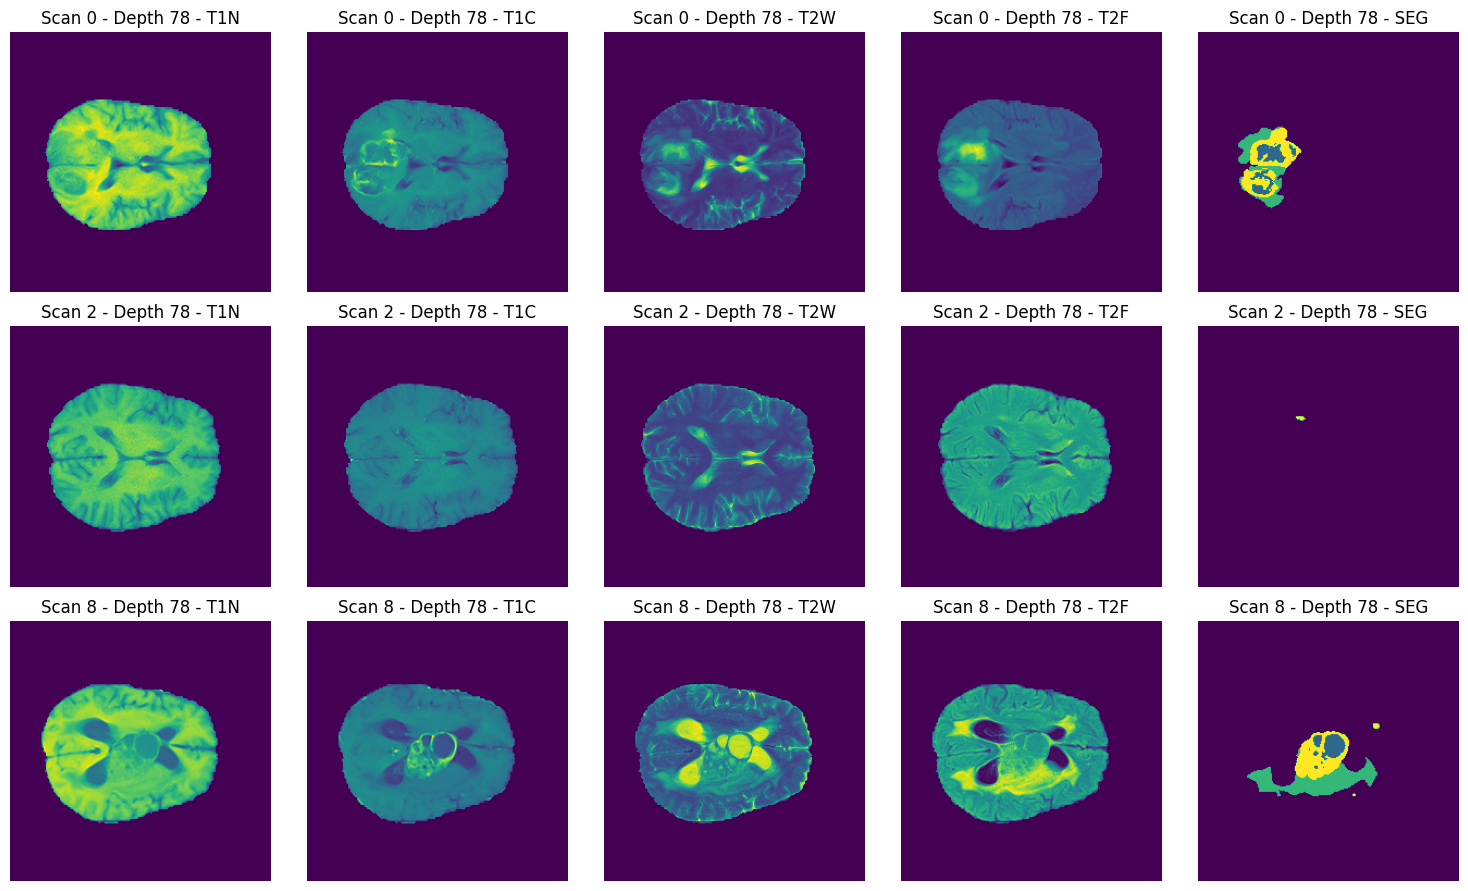

In [35]:
# Visualize some data
indices_to_inspect = [0, 2, 8]  # Indices of scans to inspect
dataset.visualize_slices(indices_to_inspect, slice_idx=78)

In [36]:
# Remove first three slices - carry no data - to make depth even number (convenient for simple CNN maxpooling/upsampling)
dataset = BrainMetastasesDataset(root_dir=dir, transform=transforms.Compose([Normalize(), ToTensor()]), start_slice=3)

## Train-test-split

In [ ]:
# Define the split sizes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
# Final check shape of tensors
for i, sample in enumerate(train_loader):
    t1n, t1c, t2w, t2f, seg = sample['t1n'], sample['t1c'], sample['t2w'], sample['t2f'], sample['seg']
    print(f'Batch {i} - t1n shape: {t1n.shape}, t1c shape: {t1c.shape}, t2w shape: {t2w.shape}, t2f shape: {t2f.shape}, seg shape: {seg.shape}')
    break

Batch 0 - t1n shape: torch.Size([2, 1, 240, 240, 152]), t1c shape: torch.Size([2, 1, 240, 240, 152]), t2w shape: torch.Size([2, 1, 240, 240, 152]), t2f shape: torch.Size([2, 1, 240, 240, 152]), seg shape: torch.Size([2, 240, 240, 152])


## Training simple 3D-CNN

### Model architecture

In [ ]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv3d(64, num_classes, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    def forward(self, x):
        # Downsample
        x = self.relu(self.conv1(x))  # [B, 8, 240, 240, 152]
        x = self.maxpool(x)           # [B, 8, 120, 120, 76]

        x = self.relu(self.conv2(x))  # [B, 16, 120, 120, 76]
        x = self.maxpool(x)           # [B, 16, 60, 60, 38]

        x = self.relu(self.conv3(x))  # [B, 32, 60, 60, 38]

        # Upsample
        x = self.upsample(x)          # [B, 32, 120, 120, 76]
        x = self.relu(self.conv4(x))  # [B, 64, 120, 120, 76]

        x = self.upsample(x)          # [B, 64, 240, 240, 152]
        x = self.relu(self.conv5(x))  # [B, num_classes, 240, 240, 152]

        return x

### Training

In [ ]:
# Function to check output logits
def check_output_logits(model, data_loader, device):
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        # Get a batch of data
        batch = next(iter(data_loader))

        # Prepare the input tensors
        t1n = batch['t1n'].to(device)
        t1c = batch['t1c'].to(device)
        t2w = batch['t2w'].to(device)
        t2f = batch['t2f'].to(device)
        seg = batch['seg'].to(device)

        # Concatenate input images along the channel dimension
        inputs = torch.cat((t1n, t1c, t2w, t2f), dim=1)

        # Run a forward pass through the model
        outputs = model(inputs)

        # Inspect the logits
        print("Output logits sample (min, max):", torch.min(outputs).item(), torch.max(outputs).item())
        print("Unique classes in output logits:", torch.unique(torch.argmax(outputs, dim=1)))

In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple3DCNN(num_classes=dataset.num_classes).to(device)
class_weights = torch.tensor([1.0 / count for count in stats['class_counts']], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 10
model.train()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_loader:
        t1n = batch['t1n'].to(device)
        t1c = batch['t1c'].to(device)
        t2w = batch['t2w'].to(device)
        t2f = batch['t2f'].to(device)
        seg = batch['seg'].to(device)

        # Concatenate input images along the channel dimension
        inputs = torch.cat((t1n, t1c, t2w, t2f), dim=1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, seg)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')
    # Monitor outputs periodically
    if (epoch + 1) % 2 == 0:  # Check outputs every 2 epochs
        check_output_logits(model, train_loader, device)
        model.train()

# Save trained model
model_path = '/content/drive/MyDrive/BraTs/models/simple_3d_cnn.pth'
torch.save(model.state_dict(), model_path)

Epoch 1/10, Loss: 1.282217454729658
Epoch 2/10, Loss: 0.9189936392235033
Output logits shape: torch.Size([2, 4, 240, 240, 152])
Output logits sample (min, max): 0.0 13.701210021972656
Unique classes in output logits: tensor([0, 1, 3], device='cuda:0')
Epoch 3/10, Loss: 0.912815914461107
Epoch 4/10, Loss: 0.8931695751168511
Output logits shape: torch.Size([2, 4, 240, 240, 152])
Output logits sample (min, max): 0.0 13.097164154052734
Unique classes in output logits: tensor([0, 1, 3], device='cuda:0')
Epoch 5/10, Loss: 0.8980958705598657
Epoch 6/10, Loss: 0.8429206695520517
Output logits shape: torch.Size([2, 4, 240, 240, 152])
Output logits sample (min, max): 0.0 19.89420509338379
Unique classes in output logits: tensor([0, 1, 3], device='cuda:0')
Epoch 7/10, Loss: 0.8254214683265397
Epoch 8/10, Loss: 0.8004704479015234
Output logits shape: torch.Size([2, 4, 240, 240, 152])
Output logits sample (min, max): 0.0 13.05768871307373
Unique classes in output logits: tensor([0, 1, 3], device='c

### Evaluation

In [ ]:
# Loading trained model from Google Drive
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = Simple3DCNN().to(device)
#model_path = '/content/drive/MyDrive/BraTs/models/simple_3d_cnn.pth'
#model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def dice_coefficient(pred, target):
    intersection = np.sum(pred * target)

    # If both pred and target are empty, return 1
    if np.sum(pred) + np.sum(target) == 0:
        return 1

    return (2. * intersection) / (np.sum(pred) + np.sum(target))

def evaluate_model(model, val_loader, device):
    model.eval()

    all_preds = []
    all_targets = []
    lesion_dice_scores = []

    with torch.no_grad():
        for batch in val_loader:
            t1n = batch['t1n'].to(device)
            t1c = batch['t1c'].to(device)
            t2w = batch['t2w'].to(device)
            t2f = batch['t2f'].to(device)
            seg = batch['seg'].to(device)

            inputs = torch.cat((t1n, t1c, t2w, t2f), dim=1)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            seg = seg.cpu().numpy()

            all_preds.extend(preds.flatten())
            all_targets.extend(seg.flatten())

            for i in range(preds.shape[0]):
                pred_batch = preds[i]
                seg_batch = seg[i]

                pred_labels, num_pred_lesions = label(pred_batch)
                seg_labels, num_seg_lesions = label(seg_batch)

                for lesion_num in range(1, num_seg_lesions + 1):  # Skipping background label 0
                    seg_lesion = seg_batch == lesion_num
                    pred_lesion_labels = pred_labels[seg_lesion]
                    pred_lesion_num = mode(pred_lesion_labels[pred_lesion_labels != 0])[0]

                    if pred_lesion_num.size > 0:
                        pred_lesion = pred_batch == pred_lesion_num
                        dice = dice_coefficient(pred_lesion, seg_lesion)
                        lesion_dice_scores.append(dice)

    mean_lesion_dice = np.mean(lesion_dice_scores) if lesion_dice_scores else 0
    print(f'Mean Lesion-wise Dice Coefficient: {mean_lesion_dice:.4f}')

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    print('Confusion Matrix:\n', cm)

    # Calculate metrics from confusion matrix
    with np.errstate(divide='ignore', invalid='ignore'):
        true_positives = np.diag(cm)
        predicted_positives = np.sum(cm, axis=0)
        actual_positives = np.sum(cm, axis=1)

        precision = np.nan_to_num(true_positives / predicted_positives)
        recall = np.nan_to_num(true_positives / actual_positives)
        f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))
        jaccard = np.nan_to_num(true_positives / (predicted_positives + actual_positives - true_positives))

        weighted_precision = np.average(precision, weights=actual_positives)
        weighted_recall = np.average(recall, weights=actual_positives)
        weighted_f1 = np.average(f1, weights=actual_positives)
        weighted_jaccard = np.average(jaccard, weights=actual_positives)

    print(f'Weighted Precision: {weighted_precision:.4f}')
    print(f'Weighted Recall: {weighted_recall:.4f}')
    print(f'Weighted F1 Score: {weighted_f1:.4f}')
    print(f'Weighted Jaccard Index: {weighted_jaccard:.4f}')

    return mean_lesion_dice, weighted_precision, weighted_recall, weighted_f1, weighted_jaccard, cm

# Evaluate the model
mean_lesion_dice, weighted_precision, weighted_recall, weighted_f1, weighted_jaccard, cm = evaluate_model(model, val_loader, device)

Mean Lesion-wise Dice Coefficient: 0.6169
Confusion Matrix:
 [[252229008  20586722         0  14535795]
 [      206     71457         0     13710]
 [   216679   1026906         0     60774]
 [     5208    129838         0     45297]]
Weighted Precision: 0.9937
Weighted Recall: 0.8734
Weighted F1 Score: 0.9295
Weighted Jaccard Index: 0.8723


### Visualizing results

In [ ]:
def visualize_predictions(model, val_loader, device, num_images=3):
    model.eval()

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= num_images:
                break

            t1n = batch['t1n'].to(device)
            t1c = batch['t1c'].to(device)
            t2w = batch['t2w'].to(device)
            t2f = batch['t2f'].to(device)
            seg = batch['seg'].to(device)

            inputs = torch.cat((t1n, t1c, t2w, t2f), dim=1)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            seg = seg.cpu().numpy()

            slice_idx = 70

            # Ground Truth
            axes[i, 0].imshow(seg[0, :, :, slice_idx])
            axes[i, 0].set_title('Ground Truth')
            axes[i, 0].axis('off')

            # Prediction
            axes[i, 1].imshow(preds[0, :, :, slice_idx])
            axes[i, 1].set_title('Prediction')
            axes[i, 1].axis('off')

            # Overlay
            overlay = seg[0, :, :, slice_idx].astype(float) * 0.5 + preds[0, :, :, slice_idx].astype(float) * 0.5
            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title('Overlay')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_loader, device)